# Compute the borders of a MOC

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mocpy import MOC

In [2]:
order = 7

fits_path = "../resources/P-GALEXGR6-AIS-FUV.fits"
moc = MOC.from_fits(fits_path)
moc = moc.degrade_to_order(order)

In [3]:
%%time
# Computing time is related to the number of ipixels located in borders of the MOC.
# GALEX has a lot of holes and therefore there are a lot of ipixels lying in its border.
# It's especially true for deeper orders.

# The step taking the most of time is the construction of the graph from the coordinates of the ipixels
# lying in the border of all the dissociated MOC components.

# For the purpose of the demo we reduce the order of GALEX from 8 to 7
boundaries_l = moc.get_boundaries()

<timed exec>:9: DeprecationWarning: This method is not stable. A future more stable algorithm will be implemented!
/home/manon.marchand/.conda/envs/mocpy-dev/lib/python3.11/site-packages/astropy_healpix/core.py:659: RuntimeWarning: invalid value encountered in neighbours_nested
  return np.stack(func(healpix_index, nside))


CPU times: user 1.26 s, sys: 38.9 ms, total: 1.3 s
Wall time: 1.3 s


In [4]:
def get_cmap(n, name="hsv"):
    """Return a colormap.

    This function maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard matplotlib
    colormap name.
    """
    return plt.get_cmap(name, n)


def add_patch_path(ax, wcs, coords, **kw_mpl_pathpatch):
    """Define a custom implementation of ``MOC.fill()``."""
    xp, yp = skycoord_to_pixel(coords=coords, wcs=wcs)
    xp = xp.flatten()
    yp = yp.flatten()
    codes = np.ones(shape=(xp.shape[0] + 1,)) * Path.LINETO
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY

    vertices = np.vstack((xp, yp)).T.tolist()
    vertices.append(vertices[0])

    path = Path(vertices, codes)

    patch = PathPatch(path, **kw_mpl_pathpatch)
    ax.add_patch(patch)

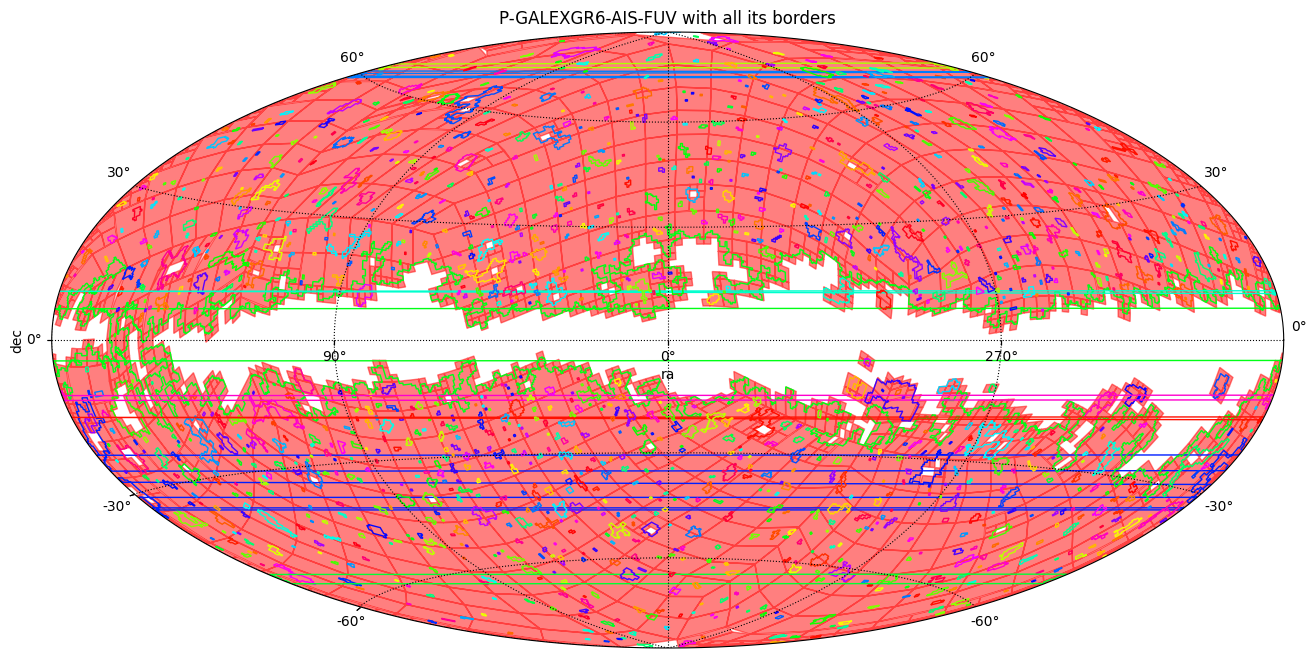

In [5]:
fig = plt.figure(111, figsize=(18, 8))
cmap = get_cmap(100)


wcs = WCS(
    {
        "naxis": 2,
        "naxis1": 324,
        "naxis2": 162,
        "crpix1": 162.5,
        "crpix2": 81.5,
        "cdelt1": -1,
        "cdelt2": 1,
        "ctype1": "GLON-AIT",
        "ctype2": "GLAT-AIT",
    },
)

ax = fig.add_subplot(111, projection=wcs, frame_class=EllipticalFrame)
moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="r")
# Draw the borders, each plotted in a different color.
for border_coords in boundaries_l:
    add_patch_path(
        ax=ax,
        wcs=wcs,
        coords=border_coords,
        fill=False,
        color=cmap(np.random.randint(100)),
    )

# WCS are defined with the origin for a pixel being in the middle while matplotlib works
# with corners
# see astropy issue for the half-pixel trick https://github.com/astropy/astropy/issues/10201
ax.set_xlim(-0.5, 324 - 0.5)
ax.set_ylim(-0.5, 162 - 0.5)
ax.set_aspect(1.0)

plt.xlabel("ra")
plt.ylabel("dec")
plt.title("P-GALEXGR6-AIS-FUV with all its borders")
plt.grid(color="black", linestyle="dotted")
# The lines cutting the MOC are borders passing from the extreme east to the extreme west of the projection
plt.show()